In [0]:
import tensorflow as tf

In [0]:
# layers
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
# model
from tensorflow.keras.models import Model
# pretrained model for transfer learning
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
# optimizers
from tensorflow.keras.optimizers import SGD, Adam
# preprocessing tools
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# glob | we need that to create generator much more easily
from glob import glob

# additional imports
import numpy as np # linear algebra | stats
import pandas as pd # data manipulation
import matplotlib.pyplot as plt
import sys, os # for glob commands (i think?)

In [0]:
# Data source : https://mmspg.epfl.ch/downloads/food-image-datasets/
# download the dataset through FTP
# its a binary classification dataset that contains food images and the images that aren't food
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip

--2020-04-15 18:53:09--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.80.48, 104.31.81.48, 2606:4700:3037::681f:5030, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.80.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  12.1MB/s    in 84s     

2020-04-15 18:54:34 (5.07 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [0]:
# unzip the data "ultra quietly"
!unzip -qq -o Food-5K.zip

In [0]:
!ls

Food-5K  Food-5K.zip  __MACOSX	sample_data


In [0]:
!ls Food-5K

evaluation  training  validation


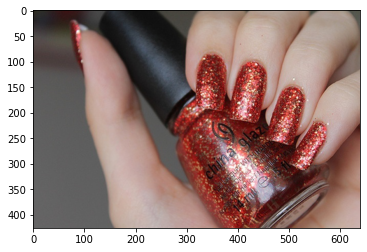

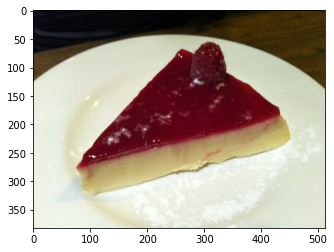

In [0]:
# data format is {label}_{image_id}.jpg
# lets take a look to few samples
plt.imshow(image.load_img("Food-5K/training/0_342.jpg"))
plt.show()
plt.imshow(image.load_img("Food-5K/training/1_342.jpg"))
plt.show()

In [0]:
# Create a folder structure for keras' image data generator
!mkdir data

In [0]:
# Make directories to store the data as Keras-style which as the following:
# data
#  - train
#     - class1
#     - class2
#     .
#     .
#     .
#  - validation
#     - class1
#     - class2
#     .
#     .
#     .
!mkdir data/train
!mkdir data/test
!mkdir data/train/food
!mkdir data/train/nonfood
!mkdir data/test/food
!mkdir data/test/nonfood

In [0]:
# Move the images to the right directory
!mv Food-5K/training/0*.jpg data/train/nonfood
!mv Food-5K/training/1*.jpg data/train/food
!mv Food-5K/validation/0*.jpg data/test/nonfood
!mv Food-5K/validation/1*.jpg data/test/food

In [0]:
train_path = 'data/train'
valid_path = 'data/test'

In [0]:
# These images are big and in different sizes,
# so pick a constant size for images (i'll use 224x224)
IMAGE_SIZE = [224,224]

In [0]:
# get the file path of every image
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [0]:
# get the total number of classes | yes we know it already but it may come handy
folders = glob(train_path + '/*')
folders # so we have the len(folders) classes

['data/train/nonfood', 'data/train/food']

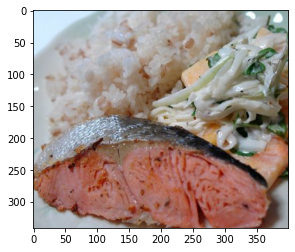

In [0]:
# pick a random image to test the structuring phase
plt.imshow(image.load_img(np.random.choice(image_files)))

In [0]:
# define the pretrained model
# the images are 224x224 but our input shape is 224x224x3 since we have 3 color channels (RGB)
# we won't include the final (head) layer of the vgg, so include_top=False
# also we use pretrained weights of imagenet dataset
ptm = PretrainedModel(
    include_top = False,
    input_shape = IMAGE_SIZE + [3],
    weights = 'imagenet',
)

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
# freeze the weights so they won't change while we using vgg16.fit() because of gradient descent
ptm.trainable = False

In [0]:
# map the data into feature vectors 
# In Keras, image data generator returns the classes as one-hot encoded so using softmax activation function would fit better to the situation.
# Because if we want to use this code in somewhere else, we wouldn't have to change the activation function everytime since softmax is for K>=2 classes

# now let's create the "head" of the vgg16
K = len(folders) # I TOLD YOU THAT IT MAY COME HANDY!
# the data is 224x224x3 now, we need to flatten it before passing to the dense layer. The output of input layer for vgg16 is already prepared
x = Flatten()(ptm.output)
x = Dense(K, activation = 'softmax')(x) # we have K=2 classes
# create the vgg16 model object
vgg16 = Model(inputs = ptm.input, outputs = x )

In [0]:
# model structure
vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
# Now I'll create a CNN model with VGG structure to compare it with pretrained model
i = Input(shape = (224,224,3))

x = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(i)
x = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(512, (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(512, (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(512, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(512, (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(512, (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(512, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(K, activation = 'softmax')(x)

vgg_structured_cnn = Model(i,x)

In [0]:
vgg_structured_cnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0   

In [0]:
# create data data generator
gen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    preprocessing_function = preprocess_input
)

In [0]:
batch_size = 64
# create the train and test generators

train_generator = gen.flow_from_directory(
    train_path,
    shuffle=True,
    target_size = IMAGE_SIZE,
    batch_size = batch_size
)


valid_generator = gen.flow_from_directory(
    valid_path,
    target_size = IMAGE_SIZE,
    batch_size = batch_size
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
# compile the both vgg16 and vgg16 structured cnn model
# yes we have 2 binary categories, 
# but since generator returns the classes as one-hot encoded, 
# categorical cross entropy would do better in general so we can use this code as template
vgg16.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

vgg_structured_cnn.compile(
    optimizer = Adam(lr = 0.05),
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

In [0]:
# fit the models to the generators
# steps_per_epoch : number of train steps per epoch
# validation_steps : same as steps_per_epoch but on validation
# both of them are defined as ceiling of (total sample / batch size)
r_vgg16 = vgg16.fit(train_generator,
                    validation_data = valid_generator,
                    epochs = 10,
                    steps_per_epoch = int(np.ceil(len(image_files) / batch_size)),
                    validation_steps = int(np.ceil(len(valid_image_files) / batch_size)))

Epoch 1/10
47/47 [==============================] - 67s 1s/step - loss: 2.4196 - accuracy: 0.9260 - val_loss: 0.8220 - val_accuracy: 0.9750
Epoch 2/10
47/47 [==============================] - 65s 1s/step - loss: 0.7580 - accuracy: 0.9760 - val_loss: 1.2336 - val_accuracy: 0.9620
Epoch 3/10
47/47 [==============================] - 65s 1s/step - loss: 0.3555 - accuracy: 0.9847 - val_loss: 0.8872 - val_accuracy: 0.9710
Epoch 4/10
47/47 [==============================] - 65s 1s/step - loss: 0.4126 - accuracy: 0.9837 - val_loss: 0.9719 - val_accuracy: 0.9720
Epoch 5/10
47/47 [==============================] - 64s 1s/step - loss: 0.1587 - accuracy: 0.9897 - val_loss: 1.3942 - val_accuracy: 0.9640
Epoch 6/10
47/47 [==============================] - 64s 1s/step - loss: 0.2407 - accuracy: 0.9917 - val_loss: 1.1477 - val_accuracy: 0.9720
Epoch 7/10
47/47 [==============================] - 64s 1s/step - loss: 0.3461 - accuracy: 0.9893 - val_loss: 1.4782 - val_accuracy: 0.9700
Epoch 8/10
47/47 [==

In [0]:
r_cnn = vgg_structured_cnn.fit(train_generator,
                    validation_data = valid_generator,
                    epochs = 10,
                    steps_per_epoch = int(np.ceil(len(image_files) / batch_size)),
                    validation_steps = int(np.ceil(len(valid_image_files) / batch_size)))

Epoch 1/10
47/47 [==============================] - 79s 2s/step - loss: 12661774694840532992.0000 - accuracy: 0.5007 - val_loss: 3002544896.0000 - val_accuracy: 0.4860
Epoch 2/10
47/47 [==============================] - 76s 2s/step - loss: 8394037248.0000 - accuracy: 0.4997 - val_loss: 396.7244 - val_accuracy: 0.4960
Epoch 3/10
47/47 [==============================] - 76s 2s/step - loss: 454.1979 - accuracy: 0.4813 - val_loss: 419.7384 - val_accuracy: 0.4880
Epoch 4/10
47/47 [==============================] - 76s 2s/step - loss: 150.2867 - accuracy: 0.4973 - val_loss: 18.2846 - val_accuracy: 0.4970
Epoch 5/10
47/47 [==============================] - 76s 2s/step - loss: 48.6180 - accuracy: 0.5020 - val_loss: 42.8669 - val_accuracy: 0.5010
Epoch 6/10
47/47 [==============================] - 76s 2s/step - loss: 35.5210 - accuracy: 0.4977 - val_loss: 40.4797 - val_accuracy: 0.4970
Epoch 7/10
47/47 [==============================] - 76s 2s/step - loss: 49.1322 - accuracy: 0.5030 - val_loss:

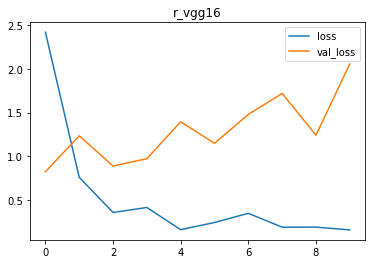

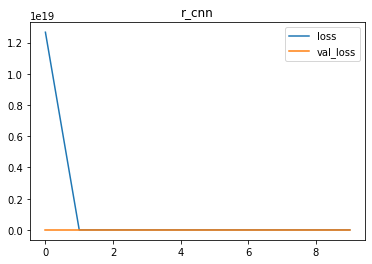

In [0]:
# plot the losses
plt.title('r_vgg16')
plt.plot(r_vgg16.history['loss'], label = 'loss')
plt.plot(r_vgg16.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

plt.title('r_cnn')
plt.plot(r_cnn.history['loss'], label = 'loss')
plt.plot(r_cnn.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()


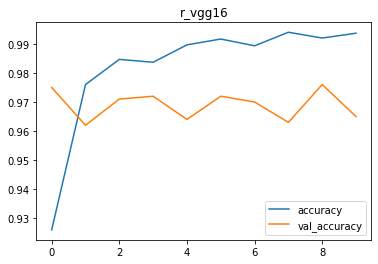

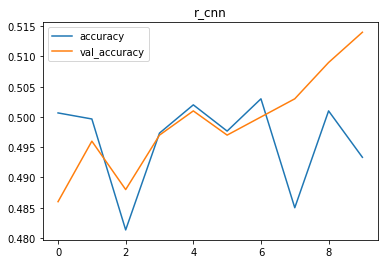

In [0]:
# plot the losses
plt.title('r_vgg16')
plt.plot(r_vgg16.history['accuracy'], label = 'accuracy')
plt.plot(r_vgg16.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

plt.title('r_cnn')
plt.plot(r_cnn.history['accuracy'], label = 'accuracy')
plt.plot(r_cnn.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.plot()
plt.show()
